# DR2-93: Implementing CIE198-SP2 using Monte Carlo Simulations

## MCS with vector values
## Demonstration based on standard functions and the class MCVectorVar

In [1]:
from empir19nrm02.tools import draw_values_gum, plotHistScales, plotCorrelation, sumMC
from empir19nrm02.tools.help import strd, label_font_size, save_fig
from empir19nrm02.MC import NameUnit, MCVar, MCVectorVar, MCSimulation, DistributionParam

import luxpy as lx
import numpy as np

import matplotlib.pyplot as plt 

out_dir = 'DR2-93'

In [2]:
## Define the number of Trials
Number_of_Trials = 10000

highRes = 1
if highRes == 0:
    wl = lx.getwlr([360,830,5])
    len_wl = len(wl)
else:
    wl = lx.getwlr([360,830,1])
    len_wl = len(wl)


In [3]:
# generate a variable with a vector of values for the BB temperature
BB_T = MCVar(name=NameUnit('BB temperature', 'K'), distribution=DistributionParam(mean=2856,stddev=5, distribution='uniform'))
BB_T.generate_numbers(Number_of_Trials)

# generate a vector for the MCS with ths SD's of the BB
mc_BB = MCVectorVar(name=NameUnit('SD BB', 'A.U.'), elements=len(wl))
mc_BB.allocate(Number_of_Trials)
# caculate the BB-SD's for the BB 
for i in range(Number_of_Trials):
    mc_BB.val[i] = lx.blackbody(BB_T.val[i], wl3=wl)[1]
mc_BB.calc_cov_matrix_from_data()
mc_BB.use_current_data = True

In [4]:
#generate the MC variables for the output
mcYxy = MCVectorVar(name=NameUnit(['L','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))


# make the MCS simple
def runSimpleMC( input, output, NumberTrials, model_function):
    # genrate an instance of the MCS class
    sim = MCSimulation(trials=NumberTrials)
    # set the input and output variables
    sim.set_input_var(input)
    sim.set_output_var(output)
    # generate the random numbers
    sim.generate()
    # calculate the output over the model_function
    sim.calculate_model( model_function)
    # return the output variable and the result database
    return sim.output_var, sim.get_result_db()

# define a simple model function
def simplest_bb_mode(i, T):
    # for demonstration purposes only, the parameter T is not used. We use the global variable mc_BB instead
    XYZ = lx.spd_to_xyz(np.vstack((wl, mc_BB.val[i])), relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')

    return [Yxy[0], CCT]

# run the simulation
input = [BB_T]
output = [mcYxy, mcCCT]

mcResult, res_data = runSimpleMC(input, output, Number_of_Trials, simplest_bb_mode)

res_data


,Input,Unit,Mean,StdDev,Distr,L,u(L),x,u(x),y,u(y),CCT,u(CCT)
0,BB temperature,K,"2,856.00000000",5.00000000,uniform,0.99999883,0.00025675,0.44753571,0.00038070,0.40742808,0.00011009,"2,856.04437714",4.99815068
0,All,,0.00000000,0.00000000,,0.99999883,0.00025675,0.44753571,0.00038070,0.40742808,0.00011009,"2,856.04437714",4.99815068


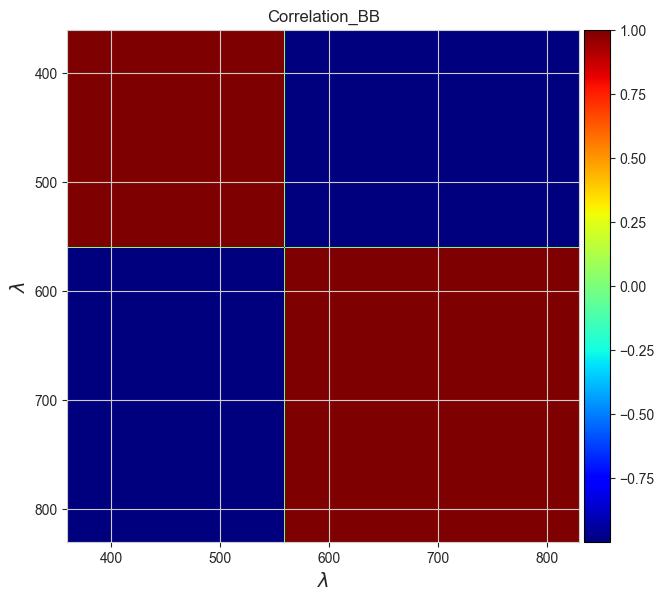

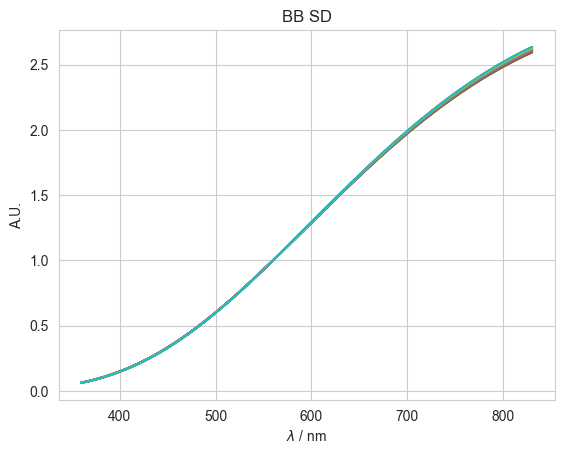

In [5]:
plotCorrelation(mc_BB.runData.corr_matrix, wl, 'Correlation_BB', x_label='$\lambda$', y_label='$\lambda$')
save_fig(out_dir, 'Vector_' + 'Correlation_BB')


for i in range(20):
    plt.plot(wl, mc_BB.val[i])
plt.xlabel('$\lambda$ / nm')
plt.ylabel('A.U.')
plt.title('BB SD')
save_fig(out_dir, 'Vector_' + 'BB_SD')



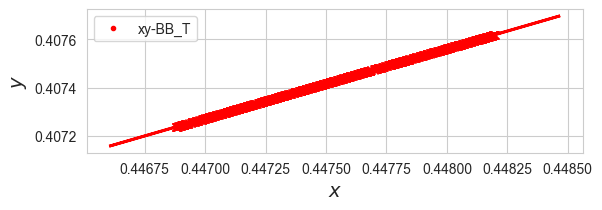

In [6]:
from empir19nrm02.tools import plot_2D

xy = mcResult[1][0] 

plot_2D(xy, number=1000, name='xy-BB_T', marker_color='r', grid=True, offset=1)
save_fig(out_dir, 'Vector_' + 'xy')

FEL integral data: CCT: [[3.0777e+03]] K, Duv: [[2.0527e-04]]


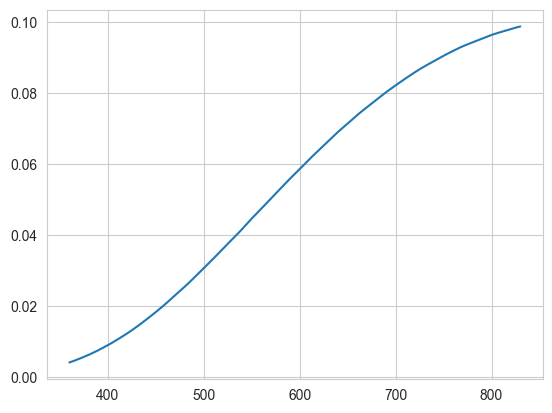

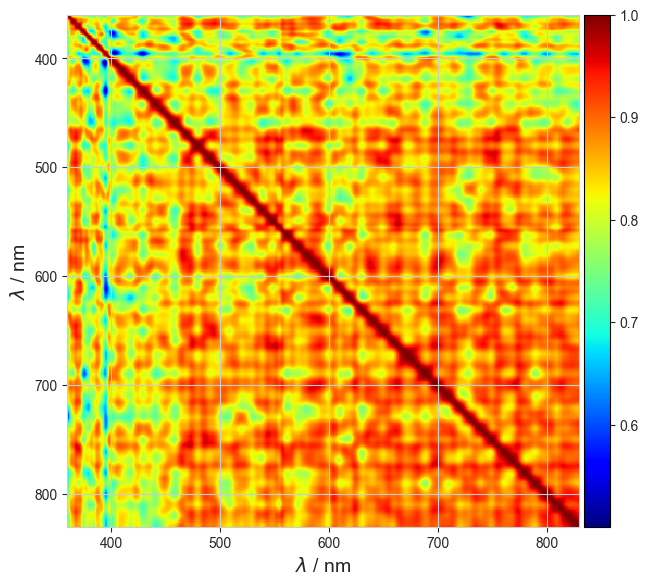

In [7]:
from empir19nrm02.MC import load_from_excel, load_from_csv
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from glob import glob
import os


file_list = glob(_CORR_PATH + "PTBResFEL-1000W-Lamp-1.csv", recursive = False)
for file in file_list:
    if 'xls' in file:
        wlFEL, mcVectorVarFEL = load_from_excel(filename= file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
    else:
        wlFEL, mcVectorVarFEL = load_from_csv(filename= file)
        XYZ_FEL = lx.spd_to_xyz(np.vstack((wlFEL, mcVectorVarFEL.setData.v_mean)), relative=False)
        CCT_FEL, duv_FEL = lx.xyz_to_cct(XYZ_FEL, out = 'cct,duv')
        print( f"FEL integral data: CCT: {CCT_FEL} K, Duv: {duv_FEL}")
    mcVectorVarFEL.interpolate(wl, wlFEL, trials=Number_of_Trials)
    file_base = os.path.basename(file)
    plt.plot(wl, mcVectorVarFEL.setData.v_mean)
    plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, '', x_label='$\lambda$ / nm', y_label='$\lambda$ / nm')


In [8]:
#generate the MC variables for the output
mcYxy = MCVectorVar(name=NameUnit(['L','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))


# make the MCS simple
def runSimpleMC( input, output, NumberTrials, model_function):
    # genrate an instance of the MCS class
    sim = MCSimulation(trials=NumberTrials)
    # set the input and output variables
    sim.set_input_var(input)
    sim.set_output_var(output)
    # generate the random numbers
    sim.generate()
    # calculate the output over the model_function
    sim.calculate_model( model_function)
    # return the output variable and the result database
    return sim.output_var, sim.get_result_db()

# define a simple model function
def simplest_bb_mode(i, T):
    # for demonstration purposes only, the parameter T is not used. We use the global variable mc_BB instead
    XYZ = lx.spd_to_xyz(np.vstack((wl, mcVectorVarFEL.val[i])), relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')

    return [Yxy[0], CCT]

# run the simulation
input = [BB_T]
output = [mcYxy, mcCCT]

mcResult, res_data = runSimpleMC(input, output, Number_of_Trials, simplest_bb_mode)

res_data

,Input,Unit,Mean,StdDev,Distr,L,u(L),x,u(x),y,u(y),CCT,u(CCT)
0,BB temperature,K,"2,856.00000000",5.00000000,uniform,0.99999301,0.00459279,0.43182882,0.00016139,0.40253997,0.00009618,"3,075.33953292",2.98540016
0,All,,0.00000000,0.00000000,,0.99999301,0.00459279,0.43182882,0.00016139,0.40253997,0.00009618,"3,075.33953292",2.98540016


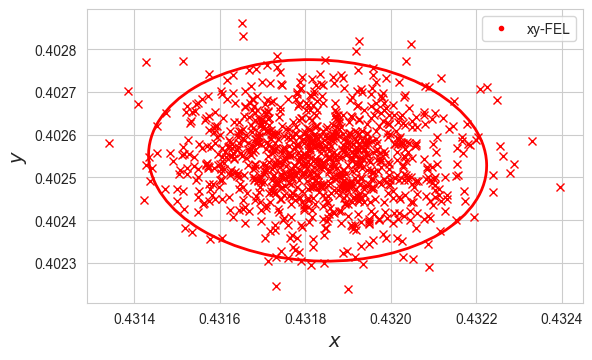

In [9]:
xyFEL = mcResult[1][0] 

plot_2D(xyFEL, number=1000, name='xy-FEL', marker_color='r', grid=True, offset=1)
save_fig(out_dir, 'Vector_' + 'xyFEL')

In [10]:
def generate_corr_numbers( vmean, vstd, corr,trials, distr = 'normal'):
    """
    Generate trials random vectors with a given mean, standard deviation and simple correlation
    distr: 'normal' or 'uniform'
    :param vmean:   mean vector
    :param vstd:    vector of standard deviations
    :param corr:    correlation between the random numbers inside the vector (simple case with one correlation only)
    :param trials:  number of trials
    :param distr:   'normal', 'uniform' or 'triangle' --> see draw_values_gum
    :return:        trials random vectors with a given mean, standard deviation and simple correlation
    """

    number = vmean.size
    v1 = np.zeros([number, trials]) 
    # start with a (0,1) distribution
    for i in range( trials):
        v1[:,i] = draw_values_gum(0, 1, distribution=distr, draws=number)
    corr_matrix = np.ones([number, number])*corr
    for i in range(number):
        corr_matrix[i,i]=1
    SD = np.ones(number)
    cov_matrix = np.outer(SD, SD)*corr_matrix
    cov_matrix_cholesky = np.linalg.cholesky(cov_matrix)
    # introduce the correlation
    v2 = np.dot(cov_matrix_cholesky, v1)
    # scale and shift the numbers
    v3=vstd[:, np.newaxis] * v2 + vmean[:, np.newaxis]
    return v3

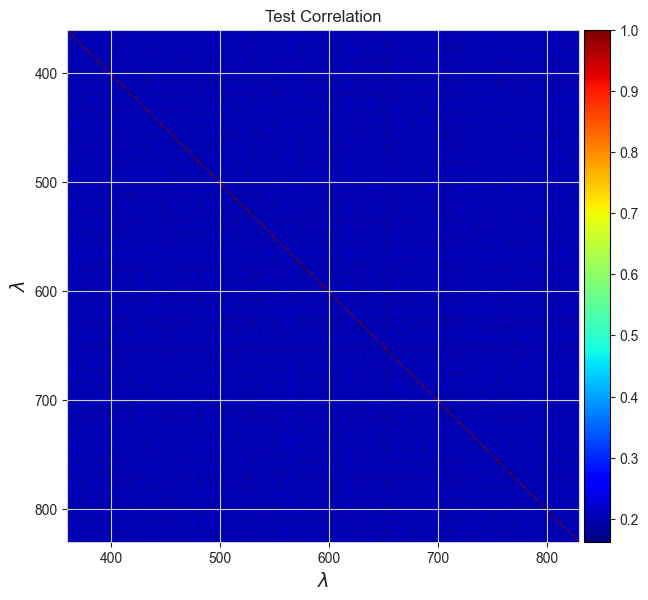

Value= [370.0291137040457, 4.00189270360954] Inteval(95%)= 14.217150837075735 U= 7.108575418537868


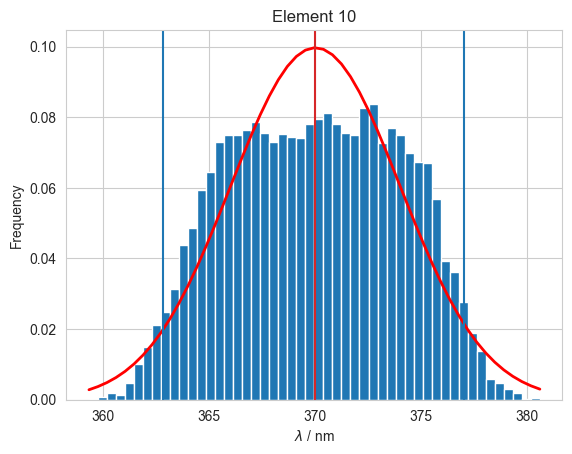

In [11]:
wl_mean = wl
wl_std = 4.*np.ones(len_wl)
v1 = generate_corr_numbers(wl_mean, wl_std, 0.2, Number_of_Trials, distr='uniform')

corr_matrix = np.corrcoef(v1)
plotCorrelation(corr_matrix, wl, 'Test Correlation', x_label='$\lambda$', y_label='$\lambda$')
save_fig(out_dir, 'Vector_' + 'Correlation')

plotHistScales(v1[10,:], title='Element 10', xLabel='$\lambda$ / nm', yLabel='Frequency', bins=50, add_distribution=True)
save_fig(out_dir, 'Vector_' + 'Element')
